In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
DATA_PATH = '/home/var/synthetic_data/dependent_gen/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [14]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.360 (2.360)	Loss 0.6889 (0.6889)	Accuracy 0.5781 (0.5781)
Batch: [5/40]	Time 0.086 (0.624)	Loss 0.5237 (0.6163)	Accuracy 0.7578 (0.6562)
Batch: [10/40]	Time 0.047 (0.489)	Loss 0.5271 (0.5739)	Accuracy 0.6953 (0.7045)
Batch: [15/40]	Time 0.052 (0.447)	Loss 0.6080 (0.5589)	Accuracy 0.6641 (0.7134)
Batch: [20/40]	Time 1.334 (0.478)	Loss 0.4229 (0.5341)	Accuracy 0.8125 (0.7303)
Batch: [25/40]	Time 0.073 (0.458)	Loss 0.3771 (0.5092)	Accuracy 0.8359 (0.7512)
Batch: [30/40]	Time 0.044 (0.429)	Loss 0.3955 (0.4944)	Accuracy 0.8516 (0.7659)
Batch: [35/40]	Time 0.055 (0.410)	Loss 0.4216 (0.4814)	Accuracy 0.8047 (0.7745)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.654 (1.654)	Loss 0.4087 (0.4087)	Accuracy 0.8125 (0.8125)
Avg validation loss: 0.4166659462451935 	 Accuracy: 0.826
--------------------
Epoch 0/20	Time 18.284 sec (18.284 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.756 (1.756)	Loss 0.3520 (0.3520)	Accuracy 0.8594 (0.8594)
Batch: [5/40]	Time 0.042 (0.558)	Loss 0.3380 (0.3735)	Accuracy 0.8594 (0.8398)
Batch: [10/40]	Time 0.076 (0.448)	Loss 0.3867 (0.3691)	Accuracy 0.8125 (0.8438)
Batch: [15/40]	Time 0.062 (0.406)	Loss 0.3659 (0.3589)	Accuracy 0.8438 (0.8467)
Batch: [20/40]	Time 1.372 (0.436)	Loss 0.3784 (0.3529)	Accuracy 0.8516 (0.8523)
Batch: [25/40]	Time 0.056 (0.393)	Loss 0.3105 (0.3460)	Accuracy 0.8594 (0.8546)
Batch: [30/40]	Time 0.052 (0.374)	Loss 0.3480 (0.3470)	Accuracy 0.8359 (0.8533)
Batch: [35/40]	Time 0.070 (0.362)	Loss 0.3920 (0.3476)	Accuracy 0.8359 (0.8533)
----------
Test: [0/4]	Time 1.600 (1.600)	Loss 0.3343 (0.3343)	Accuracy 0.8516 (0.8516)
Avg validation loss: 0.38226978802680966 	 Accuracy: 0.836
--------------------
Epoch 1/20	Time 16.323 sec (17.303 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.701 (1.701)	Loss 0.2962 (0.2962)	Accuracy 0.8906 (0.8906)
Batch: [5/40]	Time 0.042 (0.556)	Loss 0.39

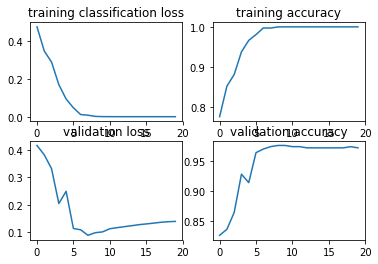

In [15]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train only adversary

In [16]:
from synthetic_dataloader import *
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [17]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [18]:
adv_encoder = LeNet()
adversary = ClassNet()

In [19]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_adv_enc = optim.Adam(adv_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)
scheduler_adv_enc = lr_scheduler.StepLR(optimizer=opt_adv_enc, gamma=0.99, step_size=1)

In [20]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv_enc.step()
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader,adv_encoder,
                                adversary, opt_adv_enc,
                                opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, adv_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.836 (1.836)	Loss 0.6934 (0.6934)	Accuracy 0.5156 (0.5156)
Batch: [5/40]	Time 0.109 (0.553)	Loss 0.3970 (0.5677)	Accuracy 0.8281 (0.6901)
Batch: [10/40]	Time 0.048 (0.444)	Loss 0.2235 (0.4190)	Accuracy 0.9297 (0.7926)
Batch: [15/40]	Time 0.060 (0.402)	Loss 0.0874 (0.3426)	Accuracy 0.9609 (0.8359)
Batch: [20/40]	Time 1.259 (0.436)	Loss 0.1017 (0.3045)	Accuracy 0.9609 (0.8594)
Batch: [25/40]	Time 0.073 (0.409)	Loss 0.0800 (0.2689)	Accuracy 0.9844 (0.8786)
Batch: [30/40]	Time 0.048 (0.389)	Loss 0.0984 (0.2428)	Accuracy 0.9609 (0.8929)
Batch: [35/40]	Time 0.037 (0.359)	Loss 0.0756 (0.2175)	Accuracy 0.9688 (0.9052)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.561 (1.561)	Loss 0.0947 (0.0947)	Accuracy 0.9531 (0.9531)
Avg validation loss: 0.0548993019759655 	 Accuracy: 0.98
--------------------
Epoch 0/20	Time 15.603 sec (15.603 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.999 (1.999)	Loss 0.0747 (0.0747)	Accuracy 0.9766 (0.9766)
Batch: [5/40]	Time 0.052 (0.599)	Loss 0.0310 (0.0500)	Accuracy 0.9844 (0.9831)
Batch: [10/40]	Time 0.040 (0.460)	Loss 0.0791 (0.0440)	Accuracy 0.9922 (0.9858)
Batch: [15/40]	Time 0.046 (0.407)	Loss 0.0572 (0.0399)	Accuracy 0.9922 (0.9883)
Batch: [20/40]	Time 1.116 (0.436)	Loss 0.0187 (0.0356)	Accuracy 1.0000 (0.9900)
Batch: [25/40]	Time 0.053 (0.417)	Loss 0.0201 (0.0323)	Accuracy 1.0000 (0.9916)
Batch: [30/40]	Time 0.050 (0.399)	Loss 0.0196 (0.0301)	Accuracy 0.9844 (0.9917)
Batch: [35/40]	Time 0.054 (0.371)	Loss 0.0058 (0.0271)	Accuracy 1.0000 (0.9928)
----------
Test: [0/4]	Time 1.715 (1.715)	Loss 0.0055 (0.0055)	Accuracy 1.0000 (1.0000)
Avg validation loss: 0.004822519898414612 	 Accuracy: 1.0
--------------------
Epoch 1/20	Time 16.358 sec (15.981 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.653 (1.653)	Loss 0.0103 (0.0103)	Accuracy 1.0000 (1.0000)
Batch: [5/40]	Time 0.175 (0.546)	Loss 0.003

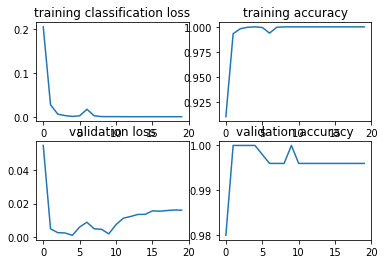

In [21]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train adversary on original encoder

## LAFTR Training

In [22]:
from synthetic_dataloader import *
gender_train = ShapeGenderDataset(train_df)
gender_valid = ShapeGenderDataset(val_df)

In [23]:
laftrtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [24]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [25]:
laftr_adv_criterion = AdvDemographicParityLoss()
laftr_cls_criterion = nn.BCELoss()

In [26]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [27]:
num_epochs = 20

clsTrain_losses = []
clsTrain_accs = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [28]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_combinedLoss, cls_en_acc, adv_loss, adv_combinedLoss, adv_acc = laftr_epoch_dp(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate_dp(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.887 (1.887)
Classifier loss 0.6932 (0.6932)	Adversary loss -0.0414 (-0.0414)
Combined Loss during classifier step 0.6930 (0.6930)	Combined Loss during adversary step -0.6379 (-0.6379)
Classifier Accuracy 0.5078 (0.5078)	Adversary Accuracy 0.5234 (0.5234)
Batch: [5/40]	Time 0.095 (0.576)
Classifier loss 0.6025 (0.6427)	Adversary loss -0.3699 (-0.2155)
Combined Loss during classifier step 0.3580 (0.5158)	Combined Loss during adversary step -0.2261 (-0.4007)
Classifier Accuracy 0.6641 (0.6055)	Adversary Accuracy 0.2188 (0.3685)
Batch: [10/40]	Time 0.082 (0.449)
Classifier loss 0.5747 (0.6111)	Adversary loss -0.5835 (-0.3666)
Combined Loss during classifier step 0.0757 (0.3320)	Combined Loss during adversary step 0.0620 (-0.2201)
Classifier Accuracy 0.7188 (0.6712)	Adversary Accuracy 0.1094 (0.2663)
Batch: [15/40]	Time 0.082 (0.410)
Classifier loss 0.4709 (0.5986)	Adversary loss -0.6557 (-0.4443)
Combined Loss during classifier step -0.1502 (0.2274)	Combined Loss durin

/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/4]	Time 1.825 (1.825)
Classifier loss 0.5853 (0.5853)	Adversary loss 0.0001 (0.0001)
Combined Loss 0.5854 (0.5854)	Classifier Accuracy 0.7500 (0.7500)	Adversary Accuracy 0.5000 (0.5000)
Classifier validation acc: 0.7300 	 Adv validation acc: 0.4800
--------------------
Epoch 0/20	Time 16.153 sec (16.153 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.107 (2.107)
Classifier loss 0.5842 (0.5842)	Adversary loss 0.0000 (0.0000)
Combined Loss during classifier step 0.5843 (0.5843)	Combined Loss during adversary step -0.5916 (-0.5916)
Classifier Accuracy 0.7266 (0.7266)	Adversary Accuracy 0.5469 (0.5469)
Batch: [5/40]	Time 0.124 (0.628)
Classifier loss 0.6048 (0.6052)	Adversary loss -0.0037 (-0.0010)
Combined Loss during classifier step 0.6034 (0.6053)	Combined Loss during adversary step -0.6137 (-0.6124)
Classifier Accuracy 0.6797 (0.6940)	Adversary Accuracy 0.5000 (0.5117)
Batch: [10/40]	Time 0.089 (0.490)
Classifier loss 0.5772 (0.6046)	Adversary loss -0.0278 (-0.0077)
Combined Loss during classifier step 0.5586 (0.6004)	Combined Loss during adversary step -0.5329 (-0.5968)
Classifier Accuracy 0.6562 (0.6520)	Adversary Accuracy 0.4844 (0.5178)
Batch: [15/40]	Time 0.083 (0.437)
Classifier loss 0.5628 (0.5939)	Adversary loss -0.0729 (-0.0217)
Combined Loss during classifier step 0.5081 (0.5793)	Combined Loss during 

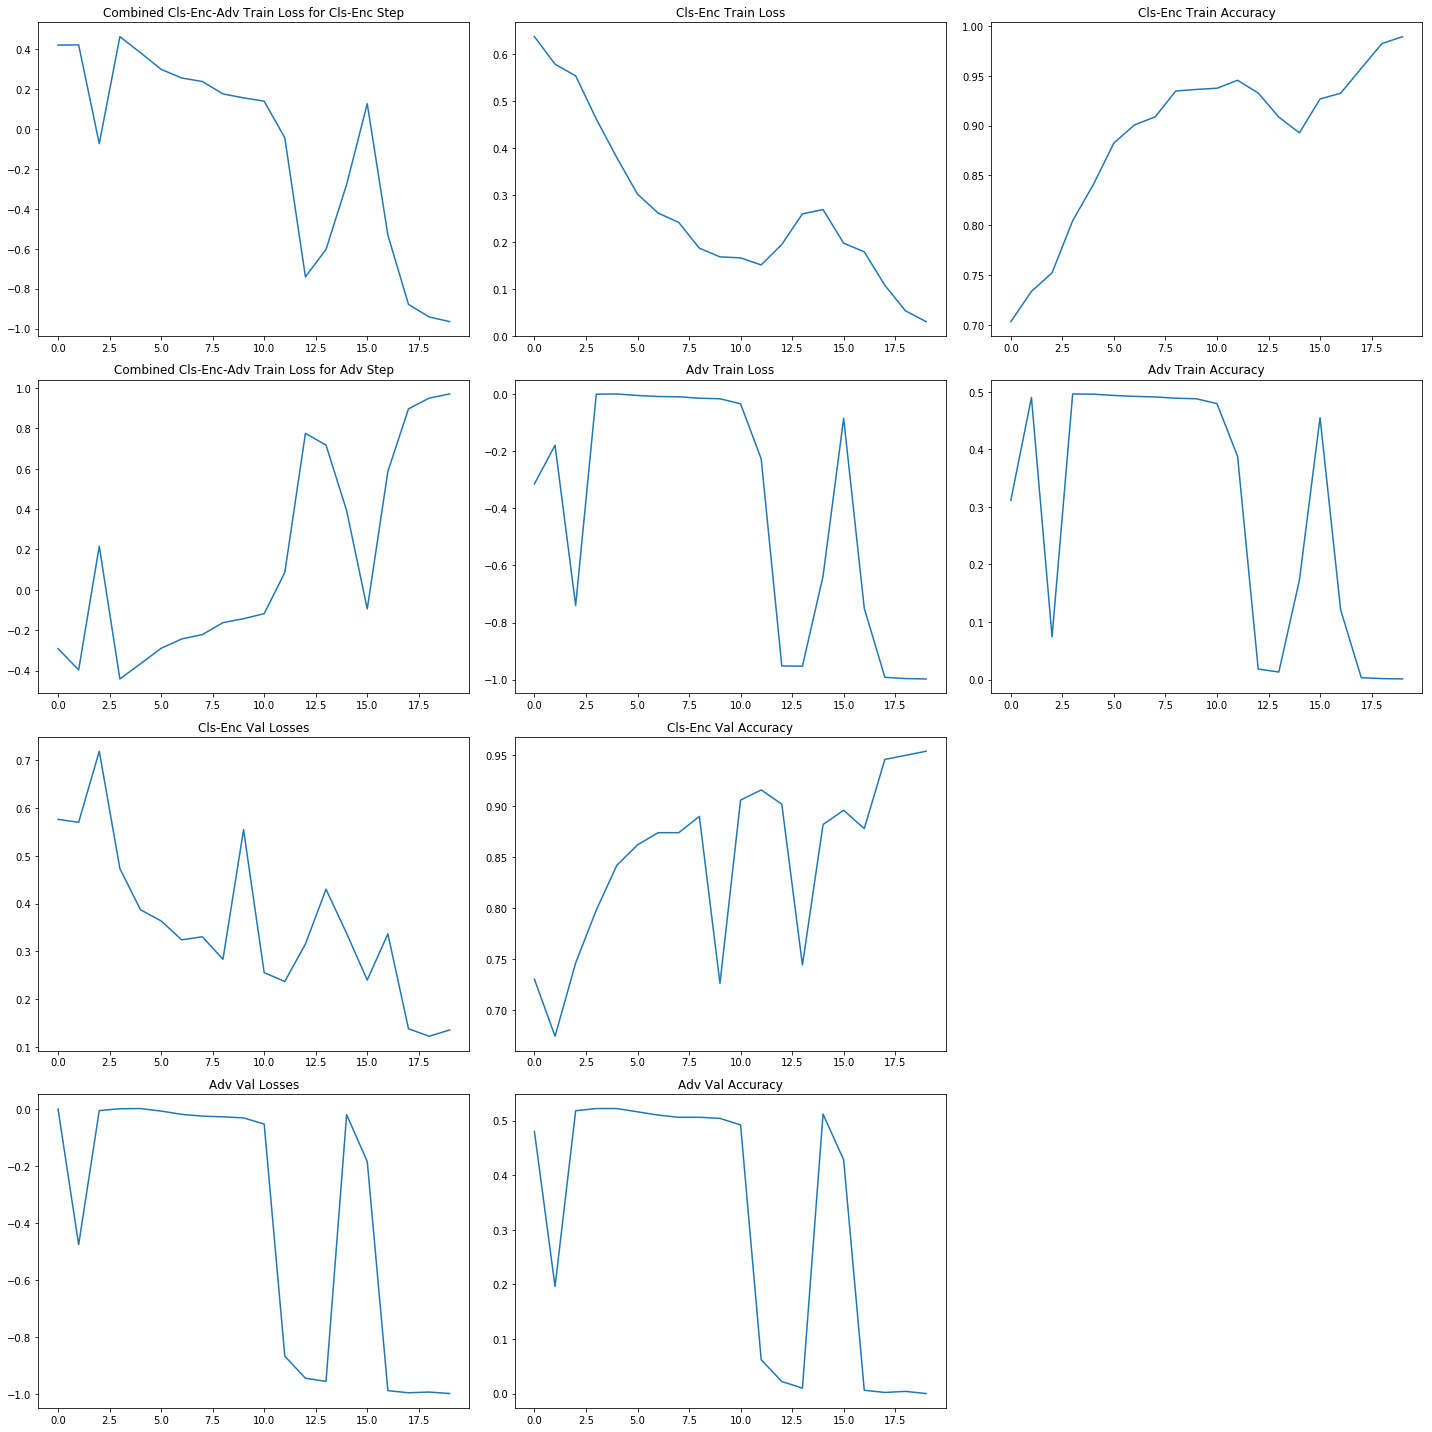

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Cls-Enc-Adv Train Loss for Cls-Enc Step')
plt.plot(clsTrainCombined_losses)
plt.subplot(432)
plt.title('Cls-Enc Train Loss')
plt.plot(clsTrain_losses)
plt.subplot(433)
plt.title('Cls-Enc Train Accuracy')
plt.plot(clsTrain_accs)
plt.subplot(434)
plt.title('Combined Cls-Enc-Adv Train Loss for Adv Step')
plt.plot(advTrainCombined_losses)
plt.subplot(435)
plt.title('Adv Train Loss')
plt.plot(advTrain_losses)
plt.subplot(436)
plt.title('Adv Train Accuracy')
plt.plot(advTrain_accs)

plt.subplot(437)
plt.title('Cls-Enc Val Losses')
plt.plot(clsVal_losses)
plt.subplot(438)
plt.title('Cls-Enc Val Accuracy')
plt.plot(clsVal_accs)
plt.subplot(4,3,10)
plt.title('Adv Val Losses')
plt.plot(advVal_losses)
plt.subplot(4,3,11)
plt.title('Adv Val Accuracy')
plt.plot(advVal_accs)

plt.tight_layout()

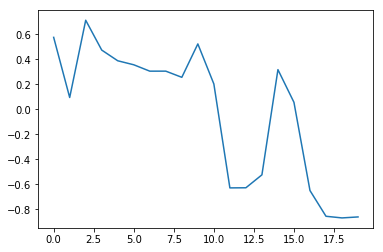

In [30]:
plt.plot(combinedVal_losses)